In [153]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data="../data/ODcounts_calibration.xlsx"
raw_data = pd.read_excel(data)

# Clean data
raw_data['OD600 (1-cm)'] /= raw_data["Scale_OD"]
raw_data["Mean_cells"] = raw_data["Cells per ml, plate counts"] # (raw_data["Cells per ml, cyto"] + raw_data["Cells per ml, plate counts"]) / 2
raw_data = raw_data.sort_values("OD600 (1-cm)")

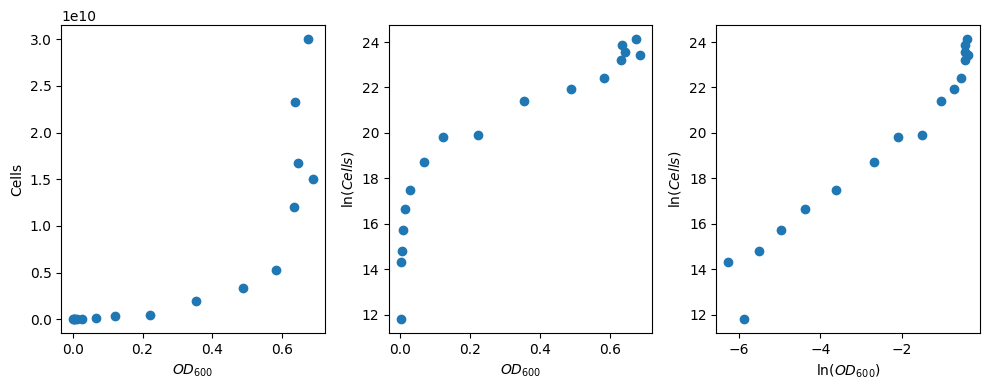

In [154]:
fig, (lin_ax, logy_ax, loglog_ax) = plt.subplots(1, 3)

od = raw_data['OD600 (1-cm)'].values.reshape(-1,1)
cells = raw_data["Mean_cells"].values.reshape(-1,1)

lin_ax.scatter(od, cells)
logy_ax.scatter(od, np.log(cells))
loglog_ax.scatter(np.log(od), np.log(cells))

lin_ax.set_xlabel("$OD_{600}$")
lin_ax.set_ylabel("Cells")
logy_ax.set_xlabel("$OD_{600}$")
logy_ax.set_ylabel("$\\ln(Cells)$")
loglog_ax.set_xlabel("$\\ln(OD_{600})$")
loglog_ax.set_ylabel("$\\ln(Cells)$")

fig.set_size_inches(10, 4)
fig.tight_layout()

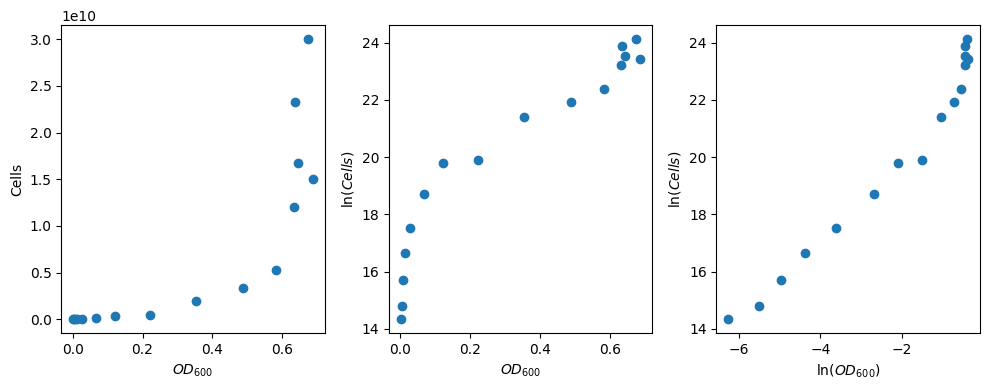

In [155]:
# Throw out outlier point
clean_data = raw_data[np.log(raw_data["Mean_cells"]) >= 13]

od = clean_data['OD600 (1-cm)'].values.reshape(-1,1)
cells = clean_data["Mean_cells"].values.reshape(-1,1)

fig, (lin_ax, logy_ax, loglog_ax) = plt.subplots(1, 3)

lin_ax.scatter(od, cells)
logy_ax.scatter(od, np.log(cells))
loglog_ax.scatter(np.log(od), np.log(cells))

lin_ax.set_xlabel("$OD_{600}$")
lin_ax.set_ylabel("Cells")
logy_ax.set_xlabel("$OD_{600}$")
logy_ax.set_ylabel("$\\ln(Cells)$")
loglog_ax.set_xlabel("$\\ln(OD_{600})$")
loglog_ax.set_ylabel("$\\ln(Cells)$")

fig.set_size_inches(10, 4)
fig.tight_layout()

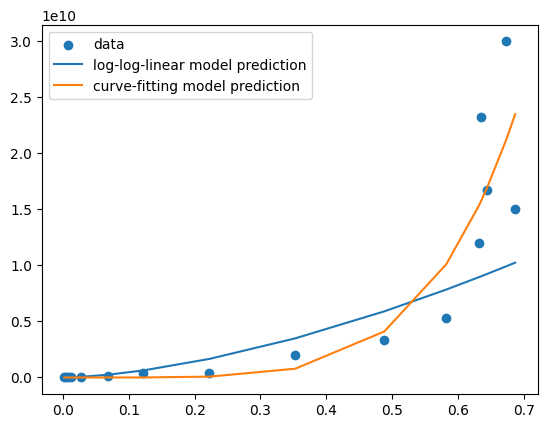

In [156]:
# Evaluate a log-log fit
loglog_model = LinearRegression()
loglog_model.fit(np.log(od), np.log(cells))
def model_form(od, a, b): return a * od**b


(a, b), pcov = curve_fit(model_form, od.flatten(), cells.flatten(),
                         p0=(np.exp(loglog_model.intercept_[0]), loglog_model.coef_[0, 0]))

pred_lm = np.exp(loglog_model.predict(np.log(od)))
pred_curve = model_form(od, a, b)

fig, ax = plt.subplots()
ax.scatter(od, cells, label="data")
ax.plot(od, pred_lm, label="log-log-linear model prediction")
ax.plot(od, pred_curve, label="curve-fitting model prediction")
ax.legend()


In [193]:
# Test performance of linear regressions as a function of cutoff for linear range

threshold = np.linspace(1.0, clean_data['OD600 (1-cm)'].min(), 10)
models = {}
loglog_mse = []
for linear_max in threshold:
    linear_range_data = clean_data[clean_data['OD600 (1-cm)'] <= linear_max]

    x = linear_range_data['OD600 (1-cm)'].values.reshape(-1, 1)
    y = linear_range_data["Mean_cells"].values.reshape(-1, 1)

    lm = LinearRegression()
    lm.fit(x, y)

    models[linear_max] = lm

    loglog_mse.append(mean_squared_error(y, model_form(x, a, b)))

fig, (fit_ax, mse_odmax_ax, mse_ax) = plt.subplots(3, 1)

# Plot fits
fit_ax.scatter(od, clean_data["Mean_cells"])
fit_ax.plot(od, model_form(od, a, b),
            "r--", label="log-log fit")
for thresh, lm in models.items():
    fit_ax.plot(od, lm.predict(od),
                label=f"$OD_{{\\max}} = {thresh:.3f}$", color=str(thresh))

# Plot MSEs for [0, OD_max]
for thresh, lm in models.items():
    mse_over_range = []
    for linear_max in threshold:
        linear_range_data = clean_data[clean_data['OD600 (1-cm)'] <= linear_max]
        x = linear_range_data['OD600 (1-cm)'].values.reshape(-1, 1)
        y = linear_range_data["Mean_cells"].values.reshape(-1, 1)

        lm_pred = lm.predict(x)
        err = mean_squared_error(y, lm_pred)
        mse_over_range.append(err)
    mse_odmax_ax.plot(threshold, mse_over_range,
                      label=f"linear fit ($OD_{{\\max}} = {thresh:.3f}$)",
                      color=str(thresh))
mse_odmax_ax.plot(threshold, loglog_mse, color="r",
                  linestyle="dashed", label="log-log fit")

# Plot MSEs on the entire range of ODs
for (thresh, lm) in models.items():
    err = mean_squared_error(cells, lm.predict(od))
    mse_ax.scatter(thresh,
                   err,
                   label=f"linear fit ($OD_{{\\max}} = {thresh:.3f}$)",
                   color=str(thresh))
mse_curvefit = mean_squared_error(cells, model_form(od, a, b))
mse_ax.hlines(mse_curvefit, 0, 1.0, color="r", linestyles="dashed")

fit_ax.set_xlabel("OD600")
fit_ax.set_ylabel("Cells")
fit_ax.set_yscale("log")
fit_ax.legend()

mse_odmax_ax.set_ylabel("MSE (when predicting on $[0, OD_{\\max}]$)")
mse_odmax_ax.set_xlabel("$OD_{\\max}$")
mse_odmax_ax.set_yscale("log")
mse_odmax_ax.legend()

mse_ax.set_ylabel("MSE (entire range)")
mse_ax.set_xlabel("$OD_{\\max}$")
mse_ax.set_yscale("log")
mse_ax.legend()

fig.set_size_inches(8, 15)


The log-log curve-fit model outperforms restricted linear fits from $OD_{\max} \approx 0.45$ onwards.
Thus, we proceed using the following calibration:

$$
\begin{align*}
\text{\# Cells}(\text{OD}_{600}) = \begin{cases} \max(1, a + b\cdot \text{OD}_{600}) && \text{OD}_{600} \le 0.45\\
                                                 c\cdot \text{OD}_{600}^d && \text{OD}_{600} > 0.45\\
\end{cases}
\end{align*}
$$

Where $a, b, c, d$ are as follows:

In [165]:
final_lm = LinearRegression()

data_45 = clean_data[clean_data["OD600 (1-cm)"] <= 0.45]
od_45 = data_45["OD600 (1-cm)"].values.reshape(-1, 1)
cells_45 = data_45["Mean_cells"].values.reshape(-1, 1)

final_lm.fit(od_45, cells_45)

print(f"a = {final_lm.intercept_[0]}")
print(f"b = {final_lm.coef_[0, 0]}")
print(f"c = {a}")
print(f"d = {b}")

a = -105927662.49527425
b = 4874064430.800461
c = 159620297822.1251
d = 5.1057490019364575


Text(0, 0.5, 'Cells')

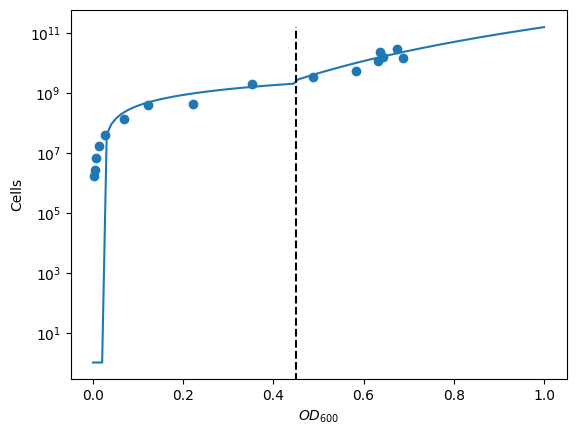

In [191]:
def predict_cells_from_OD(od):
    if not isinstance(od, np.ndarray):
        od = np.array(od)
    if len(od.shape) == 1:
        od = od.reshape(-1, 1)
    

    return np.where(od <= 0.45, np.clip(final_lm.predict(od), 1, None), model_form(od, a, b))

x = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(x, predict_cells_from_OD(x))
ax.vlines(0.45, *ax.get_ylim(), color="k", linestyles="dashed")
ax.scatter(od, cells)
ax.set_yscale("log")
ax.set_xlabel("$OD_{600}$")
ax.set_ylabel("Cells")